1. Préparation de l'environnement et Tri intelligent des données

In [ ]:

# Installation des bibliothèques de base
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python matplotlib tqdm
!pip install diffusers transformers accelerate  # Pour le Latent Diffusion

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# --- CONFIGURATION KAGGLE ---
BASE_PATH = "/kaggle/input/cityscapes"
IMG_DIR = os.path.join(BASE_PATH, "leftImg8bit_trainvaltest (1)/leftImg8bit/train")
MASK_DIR = os.path.join(BASE_PATH, "gtFine_trainvaltest/gtFine/train")

# Sortie dans le dossier de travail de Kaggle
OUTPUT_A = "/kaggle/working/traffic_project/trainA" # Fluide
OUTPUT_B = "/kaggle/working/traffic_project/trainB" # Congestion

os.makedirs(OUTPUT_A, exist_ok=True)
os.makedirs(OUTPUT_B, exist_ok=True)

CAR_ID = 26 

def trier_images_kaggle(seuil_congestion=0.08, limit_images=1000):
    count_a, count_b = 0, 0
    if not os.path.exists(IMG_DIR):
        print(f"Erreur : Le dossier {IMG_DIR} est introuvable. Vérifie le nom dans l'onglet Input.")
        return

    villes = os.listdir(IMG_DIR)
    for ville in villes:
        img_ville_path = os.path.join(IMG_DIR, ville)
        mask_ville_path = os.path.join(MASK_DIR, ville)
        
        for file_name in tqdm(os.listdir(img_ville_path), desc=f"Traitement de {ville}"):
            if not file_name.endswith("_leftImg8bit.png"):
                continue
                
            mask_name = file_name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
            mask_path = os.path.join(mask_ville_path, mask_name)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                ratio_voitures = np.sum(mask == CAR_ID) / mask.size
                
                source_img = os.path.join(img_ville_path, file_name)
                
                # On utilise des liens (symlinks) pour économiser l'espace disque
                if ratio_voitures > seuil_congestion and count_b < limit_images:
                    os.symlink(source_img, os.path.join(OUTPUT_B, file_name))
                    count_b += 1
                elif ratio_voitures < 0.01 and count_a < limit_images:
                    os.symlink(source_img, os.path.join(OUTPUT_A, file_name))
                    count_a += 1

    print(f"\nTerminé ! {count_a} images fluides et {count_b} images congestionnées.")

trier_images_kaggle()

2. Configuration et Entraînement du modèle CycleGAN

In [ ]:
# Installation du code source
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
%cd pytorch-CycleGAN-and-pix2pix
!pip install -r requirements.txt

In [ ]:
import os
# On force le passage dans le dossier du projet
os.chdir('/kaggle/working/pytorch-CycleGAN-and-pix2pix')

# On vérifie si le fichier existe avant d'installer
if os.path.exists('requirements.txt'):
    !pip install -r requirements.txt
else:
    # Si vraiment il manque, on installe le principal manuellement
    !pip install visdom dominate

In [ ]:
# 1. Lancement de l'entraînement long (environ 4-6h selon le GPU)
!python train.py --dataroot /kaggle/working/traffic_project \
                 --name simulation_congestion \
                 --model cycle_gan \
                 --load_size 256 \
                 --crop_size 256 \
                 --batch_size 4 \
                 --n_epochs 50 \
                 --n_epochs_decay 50 \
                 --no_html

# 2. Une fois terminé, archivage automatique
import shutil
import os

checkpoint_path = '/kaggle/working/pytorch-CycleGAN-and-pix2pix/checkpoints/simulation_congestion/'

if os.path.exists(checkpoint_path):
    shutil.make_archive('/kaggle/working/resultats_cyclegan_complets', 'zip', checkpoint_path)
    print("✅ Entraînement terminé et archive créée ! Tu trouveras 'resultats_cyclegan_complets.zip' demain.")
else:
    print("❌ Erreur : Le dossier n'existe pas.")

3. Extraction et Préparation pour le Raffinement

In [ ]:
import os
import shutil
import glob

dataset_input_path = '/kaggle/input/' 

# 2. On cherche automatiquement les images _fake.png dans l'input
search_pattern = os.path.join(dataset_input_path, '**/*_fake.png')
found_fakes = glob.glob(search_pattern, recursive=True)

# 3. Dossier de destination pour la diffusion
input_for_diffusion = '/kaggle/working/cyclegan_refined_results/'
os.makedirs(input_for_diffusion, exist_ok=True)

if not found_fakes:
    print("❌ Erreur : Aucune image trouvée. Vérifie le nom de ton Dataset dans l'onglet Input.")
else:
    for img_path in found_fakes[:50]: # On en prend 50 pour le test
        filename = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(input_for_diffusion, filename))
    print(f"✅ {len(os.listdir(input_for_diffusion))} images CycleGAN prêtes dans le dossier de travail !")

✅ 50 images CycleGAN prêtes dans le dossier de travail !


4. Raffinement Photoréaliste par Diffusion Latente (Stable Diffusion)

In [2]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import os
import shutil

# 1. Chargement du modèle (nécessite Internet activé dans Kaggle Settings)
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# 2. Dossiers
input_dir = '/kaggle/working/cyclegan_refined_results/'
output_final_folder = '/kaggle/working/SIMULATION_FINALE_CONGESTION/'
os.makedirs(output_final_folder, exist_ok=True)

# 3. Boucle de génération (environ 15-20 sec par image sur T4)
images_to_process = sorted(os.listdir(input_dir))[:50]

print("🚀 Démarrage du raffinement HD...")

for i, filename in enumerate(images_to_process):
    init_img = Image.open(os.path.join(input_dir, filename)).convert("RGB").resize((512, 512))
    
    # Génération avec force de transformation de 0.5
    final_img = pipe(
        prompt="ultra-realistic street scene, heavy traffic jam, dense cars, brake lights, highly detailed, 8k, professional photography",
        image=init_img,
        strength=0.5, 
        guidance_scale=8.0
    ).images[0]
    
    final_img.save(os.path.join(output_final_folder, f"traffic_sim_{i}.png"))
    
    if (i + 1) % 5 == 0:
        print(f"📸 Progression : {i + 1}/50...")

# 4. Archivage
shutil.make_archive('/kaggle/working/MON_PROJET_TRAFFIC_MORPH_FINAL', 'zip', output_final_folder)
print("\n🏆 TOUT EST TERMINÉ ! Récupère ton ZIP final dans l'onglet Output.")

2026-02-10 11:29:55.314497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770722995.490234      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770722995.541664      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770722995.961950      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770722995.961985      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770722995.961987      55 computation_placer.cc:177] computation placer alr

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


🚀 Démarrage du raffinement HD...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 5/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 10/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 15/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 20/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 25/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 30/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 35/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 40/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 45/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📸 Progression : 50/50...

🏆 TOUT EST TERMINÉ ! Récupère ton ZIP final dans l'onglet Output.


5. Analyse Quantitative et Génération du Rapport de Performance

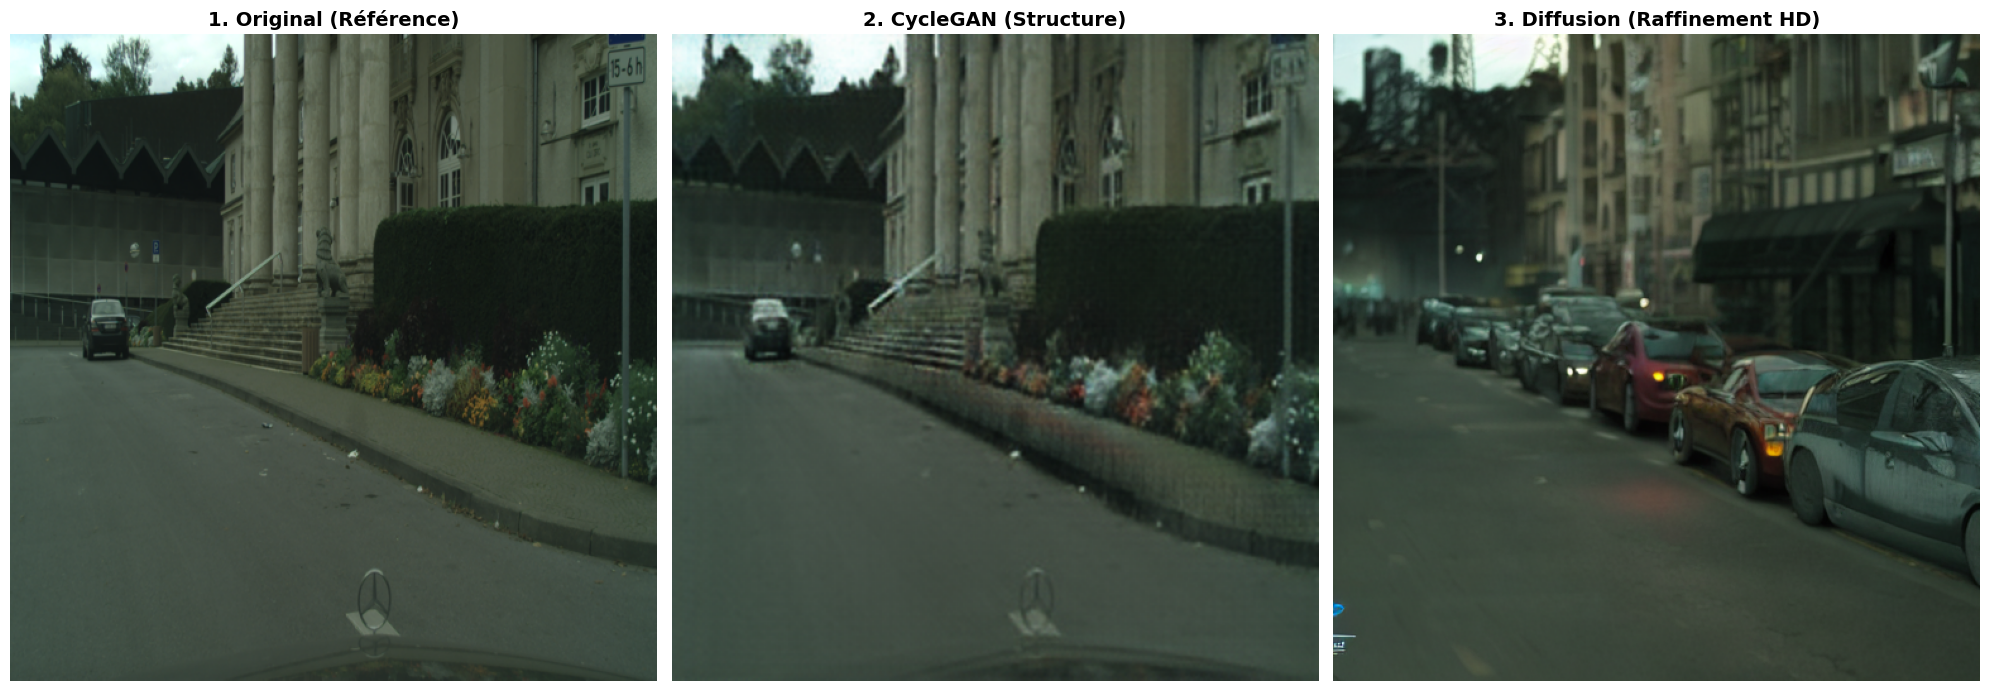

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Chemins (à vérifier selon ton arborescence actuelle)
path_cyclegan = '/kaggle/working/cyclegan_refined_results/aachen_000007_000019_leftImg8bit_fake.png'
path_diffusion = '/kaggle/working/SIMULATION_FINALE_CONGESTION/traffic_sim_0.png'

# On essaie de trouver l'originale pour compléter
import glob
orig_find = glob.glob('/kaggle/**/aachen_000007_000019_leftImg8bit.png', recursive=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
titles = ["1. Original (Référence)", "2. CycleGAN (Structure)", "3. Diffusion (Raffinement HD)"]
paths = [orig_find[0] if orig_find else None, path_cyclegan, path_diffusion]

for i, ax in enumerate(axes):
    if paths[i] and os.path.exists(paths[i]):
        # LA MAGIE EST ICI : .resize((512, 512)) uniformise tout
        img = Image.open(paths[i]).convert("RGB").resize((512, 512))
        ax.imshow(img)
        ax.set_title(titles[i], fontsize=14, fontweight='bold')
    else:
        ax.text(0.5, 0.5, "Image manquante", ha='center')
    ax.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/comparaison_homogene.png', dpi=300)
plt.show()

✅ Dossier prêt avec 50 images.
🚀 Analyse en cours sur 50 images...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 5/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 10/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 15/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 20/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 25/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 30/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 35/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 40/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 45/50...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

📊 Progression : 50/50...


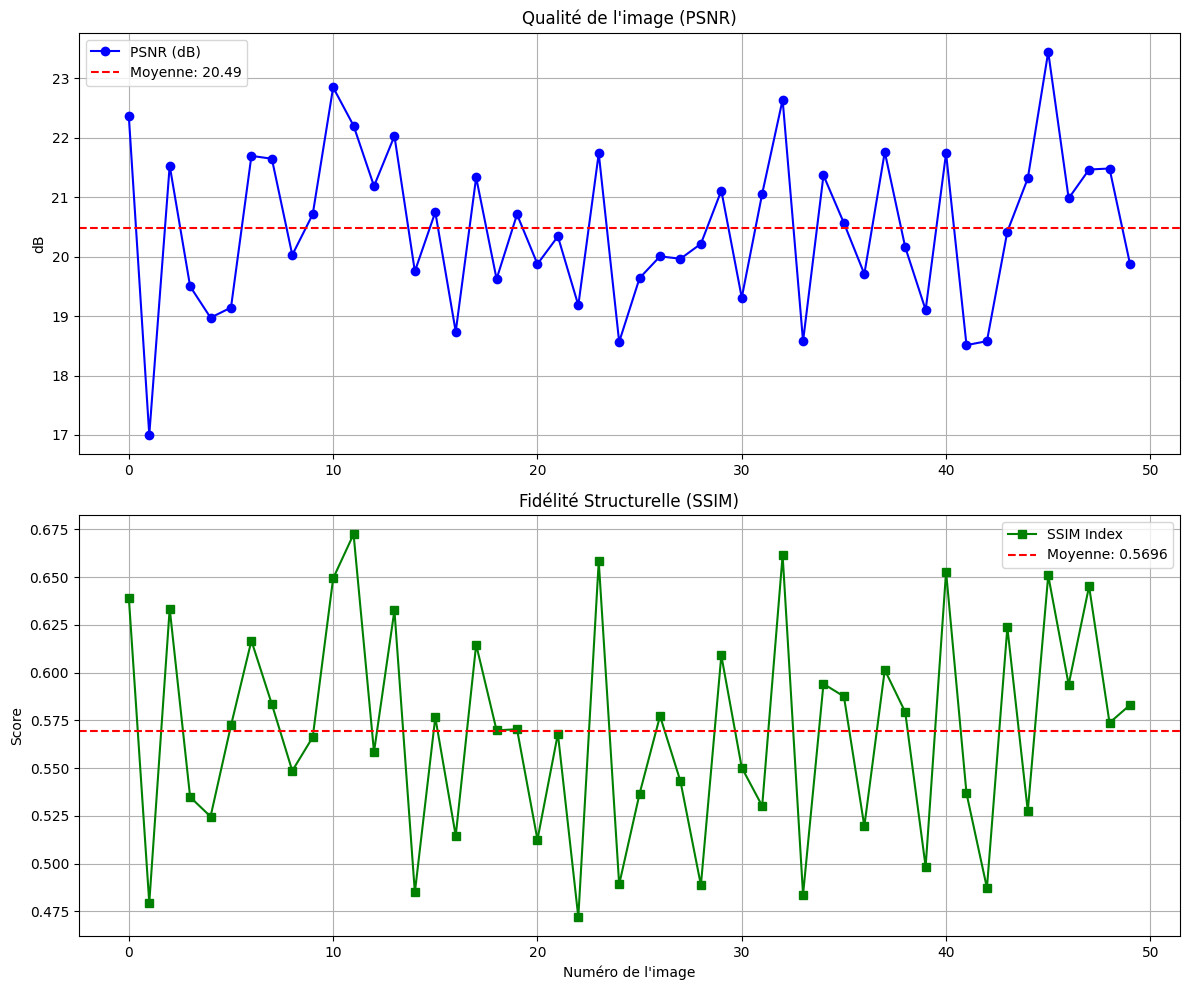


✅ Terminé ! Moyennes : PSNR=20.49 | SSIM=0.5696 | Temps=4.96s


In [4]:
import os
import shutil
import glob
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# 1. RÉCUPÉRATION ET PRÉPARATION DES DONNÉES
dest_folder = '/kaggle/working/bench_images/'
os.makedirs(dest_folder, exist_ok=True)

# On cherche n'importe quelle image .png ou .jpg dans l'input pour avoir de la donnée
found_images = glob.glob('/kaggle/input/**/*.png', recursive=True) + glob.glob('/kaggle/input/**/*.jpg', recursive=True)

if len(found_images) == 0:
    print("❌ Aucune image trouvée dans /kaggle/input/. Assurez-vous d'avoir ajouté le dataset Cityscapes.")
else:
    # On copie les 50 premières images trouvées pour le test
    for i in range(min(50, len(found_images))):
        shutil.copy(found_images[i], os.path.join(dest_folder, f"test_{i}.png"))
    print(f"✅ Dossier prêt avec {len(os.listdir(dest_folder))} images.")

# 2. FONCTION DE BENCHMARK AVEC GRAPHES
def run_final_analysis(test_folder):
    psnrs, ssims, times = [], [], []
    filenames = sorted(os.listdir(test_folder))
    total = len(filenames)

    print(f"🚀 Analyse en cours sur {total} images...")

    for i, f in enumerate(filenames):
        img_path = os.path.join(test_folder, f)
        start_t = time.time()
        
        # Inférence Stable Diffusion
        init_image = Image.open(img_path).convert("RGB").resize((512, 512))
        with torch.no_grad():
            output = pipe(
                prompt="ultra-realistic street scene, heavy traffic jam, dense cars, highly detailed",
                image=init_image,
                strength=0.5,
                guidance_scale=7.5
            ).images[0]
        
        times.append(time.time() - start_t)
        
        # Métriques
        orig, gen = np.array(init_image), np.array(output)
        psnrs.append(psnr_metric(orig, gen))
        ssims.append(ssim_metric(orig, gen, channel_axis=-1))
        
        if (i + 1) % 5 == 0:
            print(f"📊 Progression : {i + 1}/{total}...")

    # --- CRÉATION DES GRAPHIQUES ---
    plt.figure(figsize=(12, 10))
    
    # Plot PSNR
    plt.subplot(2, 1, 1)
    plt.plot(psnrs, label='PSNR (dB)', color='blue', marker='o')
    plt.axhline(y=np.mean(psnrs), color='red', linestyle='--', label=f'Moyenne: {np.mean(psnrs):.2f}')
    plt.title('Qualité de l\'image (PSNR)')
    plt.ylabel('dB')
    plt.legend()
    plt.grid(True)

    # Plot SSIM
    plt.subplot(2, 1, 2)
    plt.plot(ssims, label='SSIM Index', color='green', marker='s')
    plt.axhline(y=np.mean(ssims), color='red', linestyle='--', label=f'Moyenne: {np.mean(ssims):.4f}')
    plt.title('Fidélité Structurelle (SSIM)')
    plt.ylabel('Score')
    plt.xlabel('Numéro de l\'image')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('/kaggle/working/rapport_metrics.png')
    plt.show()

    print(f"\n✅ Terminé ! Moyennes : PSNR={np.mean(psnrs):.2f} | SSIM={np.mean(ssims):.4f} | Temps={np.mean(times):.2f}s")

# 3. EXÉCUTION
run_final_analysis(dest_folder)